In [38]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Giving image as input (not real time)

#### 0 is for masked 
#### 1 is for unmasked

In [39]:
model=load_model('mask_detector.model')

In [40]:
def detect_mask(img):
    x=image.img_to_array(img)
    x.shape
    x=x/255.0
    reshaped=np.reshape(x,(1,224,224,3))
    result=model.predict(reshaped)
    label=np.argmax(result,axis=1)[0]
    if(label == 0):
        print("Wearing Mask")
    elif(label == 1):
        print("No mask found")

In [41]:
img=image.load_img('C:/Users/KIIT/Desktop/unmasked.jfif',target_size=(224,224))

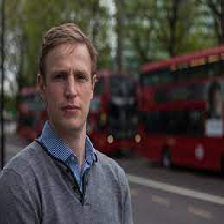

In [42]:
img

In [43]:
detect_mask(img)

No mask found


In [44]:
img=image.load_img('C:/Users/KIIT/Desktop/masked.jfif',target_size=(224,224))

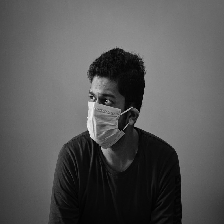

In [45]:
img

In [46]:
detect_mask(img)

Wearing Mask


In [47]:
img=image.load_img('C:/Users/KIIT/Desktop/masked3.jpg',target_size=(224,224))

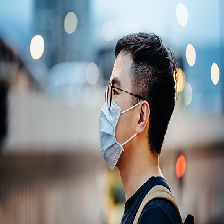

In [48]:
img

In [49]:
detect_mask(img)

Wearing Mask


In [50]:
img=image.load_img('C:/Users/KIIT/Desktop/unmasked.jpg',target_size=(224,224))

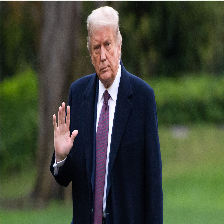

In [51]:
img

In [52]:
detect_mask(img)

No mask found


# Realtime mask detection

In [34]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

In [35]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    #blobFromImage is used for preprocessing images and preparing them for classification via pre-trained deep learning models.
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))  # parameters: (image, scalefactor=1.0, size, mean, swapRB=True)

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize our list of faces, their corresponding locations,and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is greater than the minimum confidence
    
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)


In [36]:
prototxtPath = "C:/Users/KIIT/Desktop/deploy.prototxt"      # include the model definition/architecture (i.e. layers, expected input, …..)
weightsPath = "C:/Users/KIIT/Desktop/res10_300x300_ssd_iter_140000.caffemodel"    #Neural Network weights
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)    # now we can use pre-trained Caffe model with OpenCV
                                                        #  Caffe is a deep learning framework use for object recognition

# load the face mask detector model from disk
maskNet = load_model("mask_detector.model")

In [37]:
cap=cv2.VideoCapture(0)

while cap.isOpened():
    _,frame=cap.read()
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred         # 0 for masked and 1 for not masked

        
        if mask > withoutMask:
            label="Mask"
        else:
            label="No Mask"
            
        
        if label=="Mask":
            color=(0,255,0)    #green color
        else:
            color=(0,0,255)    #red color

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)


    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the 'q' key was pressed, break from the loop
    if key == ord("q"):
        break
        
cap.release()
cv2.destroyAllWindows()